In [1]:
import numpy as np
import pandas as pd
import torch

from torch.nn.attention.flex_attention import flex_attention, create_block_mask

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from typing import Iterator

from torch.nn.functional import scaled_dot_product_attention

torch._dynamo.config.cache_size_limit = 1000

In [2]:
def create_mask_mod_naive(stm_window_size: int, mem_freq: int):
    """
    Designed for the use on the input that consists of context states with memory states mixed in.
    Does not support padding!
    """
    
    def causal_window_mask_with_mem(b, h, q_idx, kv_idx):
        is_mem_kv = (kv_idx % mem_freq == 0)
        
        causal = (kv_idx <= q_idx)
        windowed = (q_idx - kv_idx < stm_window_size)
        
        return (
                (~is_mem_kv & causal & windowed) 
                | (is_mem_kv & causal)
        )
    return causal_window_mask_with_mem


In [2]:
def create_mask_mod(context_size: int, stm_window_size: int, mem_freq: int):
    """
    Designed for the use on the input that consists of the concatenation of memory states and context states.
    Does not support padding!
    """
    n_mem = (context_size // mem_freq) + (context_size % mem_freq > 0)  # for block_size = 4: 0, 4, 8, 12, ...
    main_start = n_mem
    
    mem_end = main_start
    
    def causal_window_mask_with_mem(b, h, q_idx, kv_idx):
        # differentiator of main from mem parts
        is_mem_kv = (kv_idx < mem_end)
        is_mem_q = (q_idx < mem_end)
        
        # only valid for mem part
        mem_kv_idx = kv_idx * mem_freq  
        mem_q_idx = q_idx * mem_freq 
        
        # the first tokens are mem, so we realign with 0
        # only valid for main part
        kv_idx = kv_idx - main_start  
        q_idx = q_idx - main_start
        
        main2main_causal = (kv_idx <= q_idx)
        main2main_windowed = (q_idx - kv_idx < stm_window_size)
        
        # without window when attending to mem
        main2mem_causal = (mem_kv_idx <= q_idx) 
        mem2mem_causal = (mem_kv_idx <= mem_q_idx)
        
        mem2main_causal = (kv_idx < mem_q_idx)   # not <=!! we restrict attending to immediate token: 0 does not attend to 0 etc.
        mem2main_windowed = (mem_q_idx - kv_idx <= stm_window_size)  # not <!! extend window by 1 since we took 1 token off other side
        
        return (
                (~is_mem_kv & ~is_mem_q & main2main_causal & main2main_windowed) 
                | (is_mem_kv & ~is_mem_q & main2mem_causal)
                | (is_mem_kv & is_mem_q & mem2mem_causal)
                | (~is_mem_kv & is_mem_q & mem2main_causal & mem2main_windowed)
        )
    return causal_window_mask_with_mem


In [4]:
# visualize
def visualize_mask(mask, title="", block_size=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mask, 
        cmap="Blues", 
        cbar=False, 
        annot=False, 
        square=True,
    )
    
    # Add red grid lines for the block_size
    height, width = mask.shape
    for i in range(0, height, block_size):
        ax.axhline(i, color='red', linewidth=0.5)
    for j in range(0, width, block_size):
        ax.axvline(j, color='red', linewidth=0.5)
    
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

Possible sparsity: 47 - 78


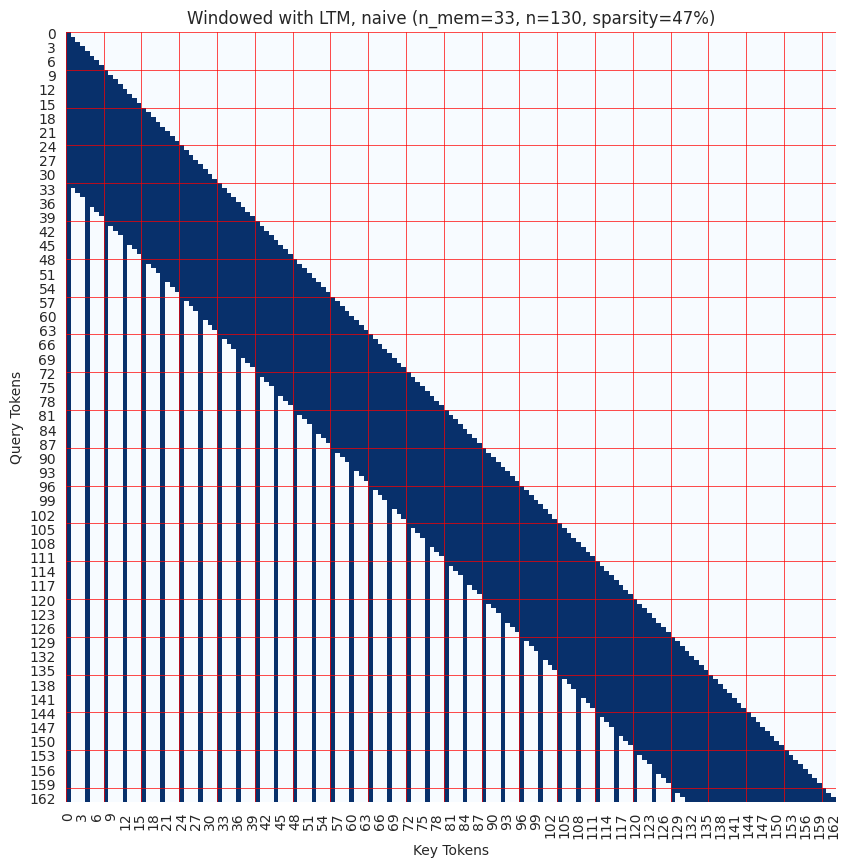

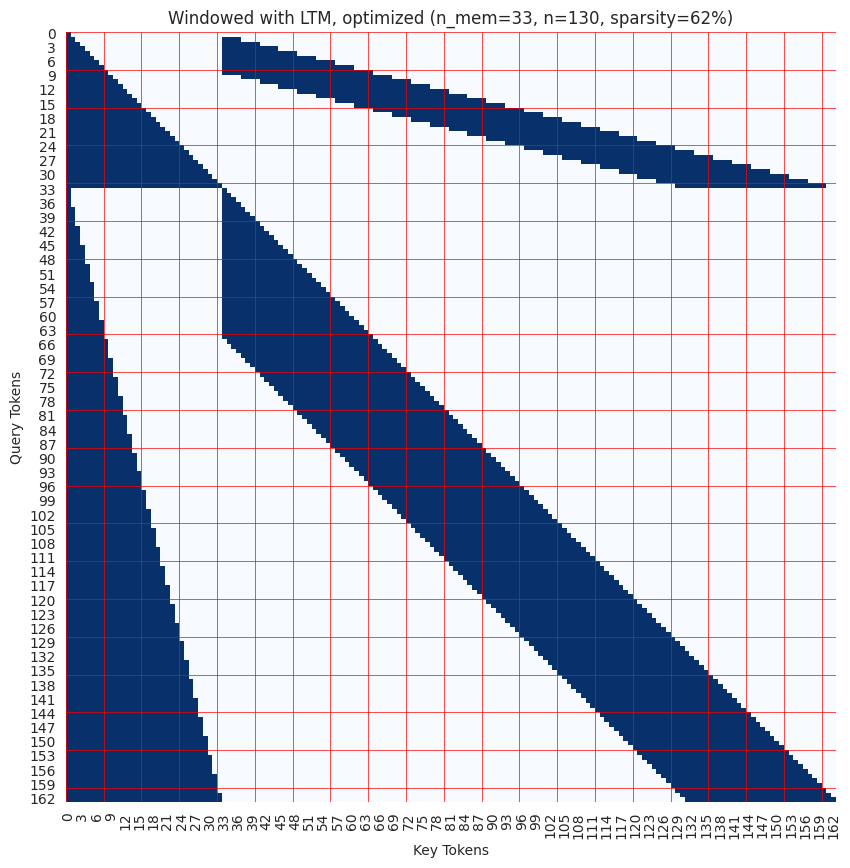

In [5]:
# x4 compression
block_size = 8
stm_window_size = 4 * block_size
mem_freq = 4  # 2 times per block
context = 130

n_mem = (context // mem_freq) + (context % mem_freq > 0)  # 0, 4, 8, 12, ...

mask_mod_opt = create_mask_mod(context, stm_window_size, mem_freq)
mask_mod_naive = create_mask_mod_naive(stm_window_size, mem_freq)

n = n_mem + context
mask_opt = np.zeros((n, n), dtype=bool)
mask_naive = np.zeros((n, n), dtype=bool)
for q_idx in range(n):
    for kv_idx in range(n):
        mask_opt[q_idx, kv_idx] = mask_mod_opt(0, 0, q_idx, kv_idx)
        mask_naive[q_idx, kv_idx] = mask_mod_naive(0, 0, q_idx, kv_idx)

min_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: q_idx >= kv_idx, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
max_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: (q_idx >= kv_idx) & (q_idx - kv_idx < stm_window_size), None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
opt_sparsity = int(create_block_mask(mask_mod_opt, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
naive_sparsity = int(create_block_mask(mask_mod_naive, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())

print(f'Possible sparsity: {min_sparsity} - {max_sparsity}')
visualize_mask(
    mask_naive, 
    title=f'Windowed with LTM, naive (n_mem={n_mem}, n={context}, sparsity={naive_sparsity}%)', 
    block_size=block_size
)
visualize_mask(
    mask_opt, 
    title=f'Windowed with LTM, optimized (n_mem={n_mem}, n={context}, sparsity={opt_sparsity}%)', 
    block_size=block_size
)

Possible sparsity: 48 - 89


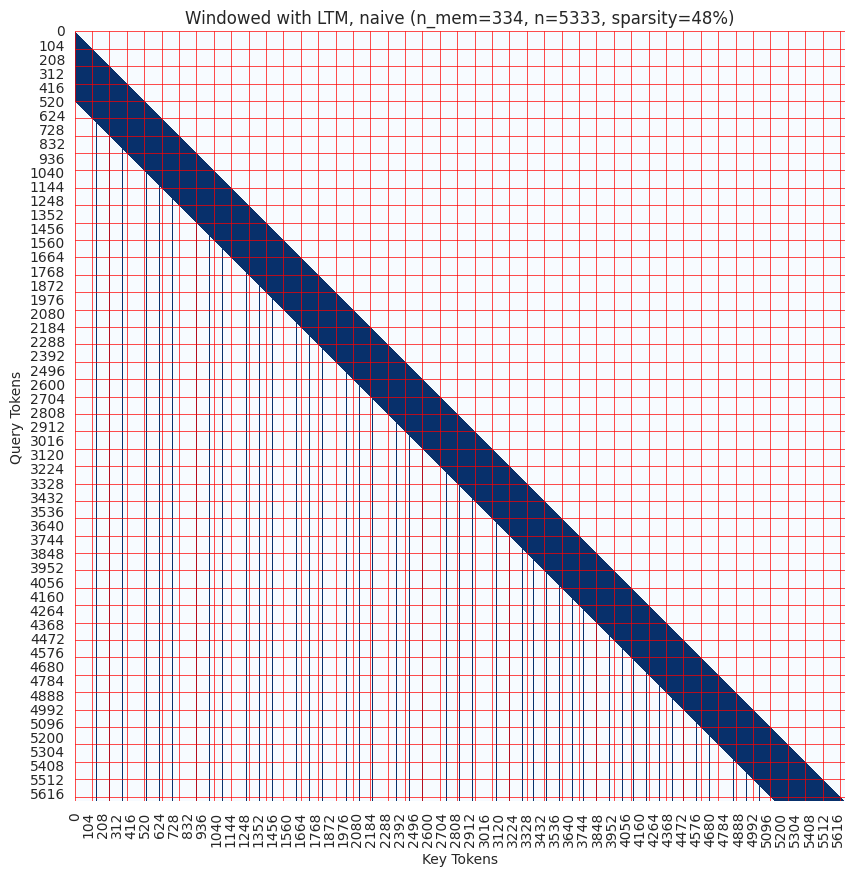

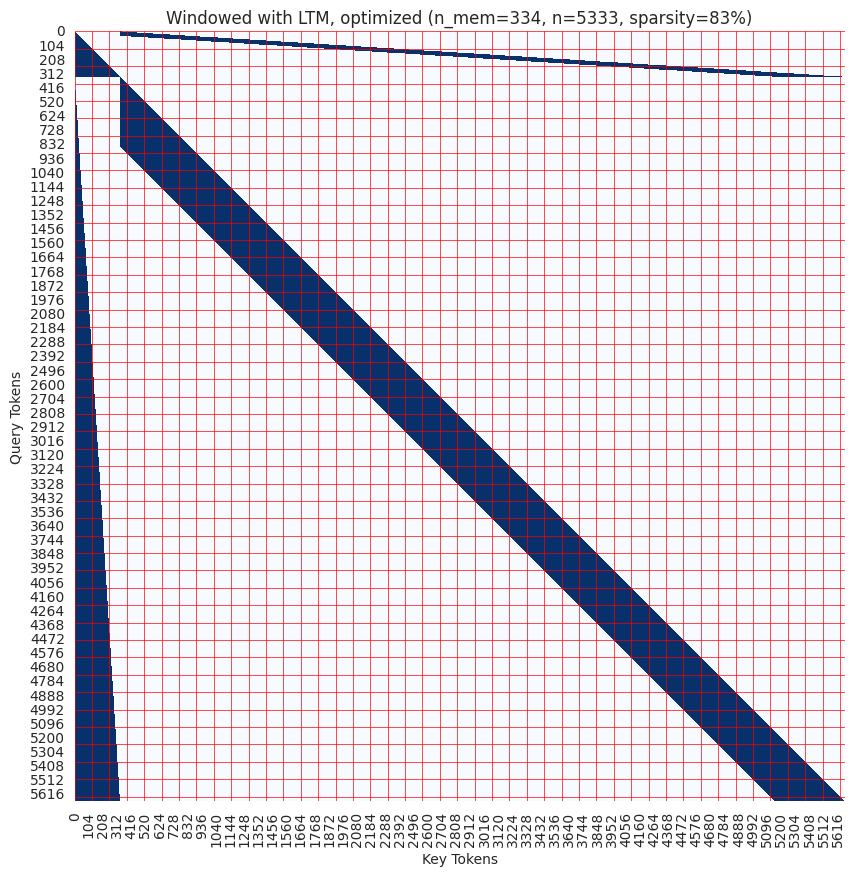

In [6]:
# x16 compression
block_size = 128
stm_window_size = 4 * block_size
mem_freq = 16  # 8 times per block
context = 5333

n_mem = (context // mem_freq) + (context % mem_freq > 0)  # 0, 4, 8, 12, ...

mask_mod_opt = create_mask_mod(context, stm_window_size, mem_freq)
mask_mod_naive = create_mask_mod_naive(stm_window_size, mem_freq)

n = n_mem + context
mask_opt = np.zeros((n, n), dtype=bool)
mask_naive = np.zeros((n, n), dtype=bool)
for q_idx in range(n):
    for kv_idx in range(n):
        mask_opt[q_idx, kv_idx] = mask_mod_opt(0, 0, q_idx, kv_idx)
        mask_naive[q_idx, kv_idx] = mask_mod_naive(0, 0, q_idx, kv_idx)

min_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: q_idx >= kv_idx, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
max_sparsity = int(create_block_mask(lambda b, h, q_idx, kv_idx: (q_idx >= kv_idx) & (q_idx - kv_idx < stm_window_size), None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
opt_sparsity = int(create_block_mask(mask_mod_opt, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())
naive_sparsity = int(create_block_mask(mask_mod_naive, None, None, n, n, BLOCK_SIZE=block_size, device='cpu').sparsity())

print(f'Possible sparsity: {min_sparsity} - {max_sparsity}')
visualize_mask(
    mask_naive, 
    title=f'Windowed with LTM, naive (n_mem={n_mem}, n={context}, sparsity={naive_sparsity}%)', 
    block_size=block_size
)
visualize_mask(
    mask_opt, 
    title=f'Windowed with LTM, optimized (n_mem={n_mem}, n={context}, sparsity={opt_sparsity}%)', 
    block_size=block_size
)

In [3]:
# benchmark forward
batch_size = 1

block_size = 128
window_size = block_size * 8
compile_warmup = 100
n_trials = 100

min_blocks = 1
max_blocks = 1000

# llama3 8b 
kv_heads = 32 # 8
q_heads = 32
head_dim = 4096 // q_heads

data = []
context_sizes = [block_size * i for i in range(min_blocks, max_blocks, 50)]

mem_freqs = [2, 8, 32, 128]

In [4]:
def benchmark(
        attn_impl, input_len: int, res_base: dict, do_compile: bool = True, dtype=torch.bfloat16, 
        **extra_kwargs
) -> Iterator[dict]:
    torch.compiler.reset()
    attn_impl = torch.compile(attn_impl, dynamic=False, mode='max-autotune-no-cudagraphs') if do_compile else attn_impl
    
    # compilation warmup
    if do_compile:
        with torch.autograd.profiler.profile(use_device='cuda') as prof:
            for _ in range(compile_warmup):
                input_k = torch.randn(size=(batch_size, input_len, kv_heads, head_dim), dtype=dtype, device='cuda')
                input_v = torch.randn(size=(batch_size, input_len, kv_heads, head_dim), dtype=dtype, device='cuda')
                input_q = torch.randn(size=(batch_size, input_len, q_heads, head_dim), dtype=dtype, device='cuda')
                
                with torch.no_grad():
                    assert attn_impl(input_q, input_k, input_v, **extra_kwargs) is not None
            torch.cuda.synchronize(device=None)
            
        print(f'Compiled time: {(prof.profiling_end_time_ns - prof.profiling_start_time_ns) / 1e6:.4f}ms')

    for _ in range(n_trials):
        input_k = torch.randn(size=(batch_size, input_len, kv_heads, head_dim), dtype=dtype, device='cuda')
        input_v = torch.randn(size=(batch_size, input_len, kv_heads, head_dim), dtype=dtype, device='cuda')
        input_q = torch.randn(size=(batch_size, input_len, q_heads, head_dim), dtype=dtype, device='cuda')
        
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize(device=None)
        
        with torch.autograd.profiler.profile(use_device='cuda') as prof:
            with torch.no_grad():
                assert attn_impl(input_q, input_k, input_v, **extra_kwargs).sum() < torch.inf
                torch.cuda.synchronize(device=None)
        
        peak_mem = torch.cuda.max_memory_allocated()
        
        time_ns = prof.profiling_end_time_ns - prof.profiling_start_time_ns
        
        # Record results
        yield {
            **res_base,
            'time_taken_ms': time_ns / 1e6,
            'memory_used_mb': peak_mem / 1024 / 1024
        }

In [5]:
# causal sdpa 

for context_size in tqdm(context_sizes):
    try:
        curr_res = []
        for res in benchmark(
                scaled_dot_product_attention, context_size, 
                {'impl': 'sdpa_causal', 'context_length': context_size}, 
                enable_gqa=False, is_causal=True
        ):
            data.append(res)
            curr_res.append(res)
        
        print(f'Sum time: {pd.DataFrame(curr_res)["time_taken_ms"].sum():.4f}ms')
    except Exception as e:
        print(e)
        break

  0%|          | 0/20 [00:00<?, ?it/s]

Compiled time: 2983.7789ms
Sum time: 108.6278ms
Compiled time: 115.6630ms
Sum time: 80.9926ms
Compiled time: 141.6109ms
Sum time: 98.5907ms
Compiled time: 171.0560ms
Sum time: 115.0706ms
Compiled time: 203.5728ms
Sum time: 131.3702ms
Compiled time: 232.2779ms
Sum time: 147.6060ms
Compiled time: 262.5147ms
Sum time: 167.0865ms
Compiled time: 301.6204ms
Sum time: 182.3765ms
Compiled time: 337.4674ms
Sum time: 201.9323ms
Compiled time: 372.9495ms
Sum time: 220.3531ms
Compiled time: 393.6220ms
Sum time: 228.1822ms
CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [6]:
# causal flex

def causal_mask_mod(b, h, q_idx, kv_idx):
    return kv_idx <= q_idx


for context_size in tqdm(context_sizes):
    mask = create_block_mask(causal_mask_mod, None, None, context_size, context_size, device='cuda', BLOCK_SIZE=block_size, _compile=True)
    print(f'Sparsity: {mask.sparsity():.2f}%')
    
    try:
        curr_res = []
        for res in benchmark(
                flex_attention, context_size, 
                {'impl': 'flex_causal', 'context_length': context_size}, 
                enable_gqa=False, block_mask=mask
        ):
            data.append(res)
            curr_res.append(res)
        
        print(f'Sum time: {pd.DataFrame(curr_res)["time_taken_ms"].sum():.4f}ms')
    except Exception as e:
        print(e)
        break

  0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.00%
Compiled time: 522.3458ms
Sum time: 61.5724ms
Sparsity: 49.02%
Compiled time: 495.4525ms
Sum time: 67.7638ms
Sparsity: 49.50%
Compiled time: 526.9440ms
Sum time: 84.9513ms
Sparsity: 49.67%
Compiled time: 582.1604ms
Sum time: 104.4056ms
Sparsity: 49.75%
Compiled time: 531.1406ms
Sum time: 119.2980ms
Sparsity: 49.80%
Compiled time: 572.4590ms
Sum time: 136.2851ms
Sparsity: 49.83%
Compiled time: 606.5143ms
Sum time: 153.6280ms
Sparsity: 49.86%
Compiled time: 644.3117ms
Sum time: 170.3975ms
Sparsity: 49.88%
Compiled time: 699.9464ms
Sum time: 190.9446ms
Sparsity: 49.89%
Compiled time: 709.9391ms
Sum time: 204.8691ms
Sparsity: 49.90%
Compiled time: 710.8938ms
Sum time: 218.8029ms
Sparsity: 49.91%
Compiled time: 763.4530ms
Sum time: 236.7606ms
Sparsity: 49.92%
Compiled time: 801.6989ms
Sum time: 253.7729ms
Sparsity: 49.92%
Compiled time: 825.6318ms
Sum time: 269.1135ms
Sparsity: 49.93%
Compiled time: 854.9076ms
Sum time: 292.2213ms
Sparsity: 49.93%
Compiled time: 882.4526ms
S

In [7]:
# causal window attention 

def window_mask_mod(b, h, q_idx, kv_idx):
    return (kv_idx <= q_idx) & (q_idx - kv_idx < window_size)


for context_size in tqdm(context_sizes):
    mask = create_block_mask(window_mask_mod, None, None, context_size, context_size, device='cuda', BLOCK_SIZE=block_size, _compile=True)
    print(f'Sparsity: {mask.sparsity():.2f}%')
    
    try:
        for res in benchmark(
                flex_attention, context_size, 
                {'impl': 'flex_window', 'context_length': context_size}, 
                enable_gqa=True, block_mask=mask
        ):
            data.append(res)
    except Exception as e:
        print(e)
        break

  0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.00%
Compiled time: 442.2205ms
Sparsity: 83.74%
Compiled time: 455.3099ms
Sparsity: 91.44%
Compiled time: 475.5191ms
Sparsity: 94.20%
Compiled time: 506.1295ms
Sparsity: 95.61%
Compiled time: 542.0677ms
Sparsity: 96.47%
Compiled time: 570.5679ms
Sparsity: 97.05%
Compiled time: 604.6231ms
Sparsity: 97.47%
Compiled time: 636.9149ms
Sparsity: 97.78%
Compiled time: 670.4203ms
Sparsity: 98.02%
Compiled time: 696.8514ms
Sparsity: 98.22%
Compiled time: 736.2988ms
Sparsity: 98.38%
Compiled time: 760.6493ms
Sparsity: 98.51%
Compiled time: 785.2430ms
Sparsity: 98.63%
Compiled time: 807.4196ms
Sparsity: 98.72%
Compiled time: 855.4921ms
Sparsity: 98.81%
Compiled time: 878.1809ms
Sparsity: 98.88%
Compiled time: 908.2038ms
Sparsity: 98.95%
Compiled time: 939.2273ms
Sparsity: 99.01%
Compiled time: 972.0935ms
Sparsity: 99.06%
Compiled time: 988.4848ms


In [54]:
# causal window attention with memory

for context_size in tqdm(context_sizes):
    try:
        for mem_freq in tqdm(mem_freqs, leave=False):
            mem_size = (context_size // mem_freq) + (context_size % mem_freq > 0)
            mask = create_block_mask(
                create_mask_mod(context_size, window_size, mem_freq), 
                None, None, context_size + mem_size, context_size + mem_size, device='cuda', BLOCK_SIZE=block_size,
                _compile=True
            )
            print(f'Sparsity: {mask.sparsity():.2f}%')
            
            for res in benchmark(
                flex_attention, context_size, 
                {'impl': f'flex_window_mem_compr{mem_freq}', 'context_length': context_size}, 
                enable_gqa=True, block_mask=mask
            ):
                data.append(res)
    except Exception as e:
        print(e)
        break

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 0.00%
Compiled time: 524.2507ms
Sparsity: 0.00%
Compiled time: 476.8956ms
Sparsity: 25.00%
Compiled time: 482.7084ms
Sparsity: 25.00%
Compiled time: 478.8539ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 70.52%
Compiled time: 492.7056ms
Sparsity: 77.41%
Compiled time: 496.7512ms
Sparsity: 79.85%
Compiled time: 495.3247ms
Sparsity: 80.58%
Compiled time: 492.6101ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 76.64%
Compiled time: 528.2616ms
Sparsity: 85.51%
Compiled time: 526.8553ms
Sparsity: 88.83%
Compiled time: 536.0380ms
Sparsity: 89.67%
Compiled time: 536.2405ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 78.80%
Compiled time: 556.7321ms
Sparsity: 88.39%
Compiled time: 558.9384ms
Sparsity: 91.89%
Compiled time: 559.2502ms
Sparsity: 92.87%
Compiled time: 570.0615ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 79.91%
Compiled time: 587.4488ms
Sparsity: 89.89%
Compiled time: 584.3553ms
Sparsity: 93.51%
Compiled time: 579.7954ms
Sparsity: 94.50%
Compiled time: 552.5207ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 80.58%
Compiled time: 604.9055ms
Sparsity: 90.78%
Compiled time: 600.4411ms
Sparsity: 94.48%
Compiled time: 598.8203ms
Sparsity: 95.52%
Compiled time: 598.9178ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 81.03%
Compiled time: 621.5727ms
Sparsity: 91.38%
Compiled time: 608.4789ms
Sparsity: 95.14%
Compiled time: 604.6296ms
Sparsity: 96.19%
Compiled time: 596.3681ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 81.36%
Compiled time: 634.3163ms
Sparsity: 91.81%
Compiled time: 653.9529ms
Sparsity: 95.61%
Compiled time: 644.2335ms
Sparsity: 96.67%
Compiled time: 630.1678ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 81.60%
Compiled time: 647.0188ms
Sparsity: 92.14%
Compiled time: 654.5559ms
Sparsity: 95.97%
Compiled time: 669.5283ms
Sparsity: 97.04%
Compiled time: 669.0524ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 81.79%
Compiled time: 811.2519ms
Sparsity: 92.39%
Compiled time: 662.2279ms
Sparsity: 96.25%
Compiled time: 682.1356ms
Sparsity: 97.32%
Compiled time: 698.2816ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 81.95%
Compiled time: 692.8326ms
Sparsity: 92.59%
Compiled time: 695.6261ms
Sparsity: 96.47%
Compiled time: 720.5651ms
Sparsity: 97.55%
Compiled time: 700.4555ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.07%
Compiled time: 703.1204ms
Sparsity: 92.76%
Compiled time: 751.5735ms
Sparsity: 96.66%
Compiled time: 729.3112ms
Sparsity: 97.73%
Compiled time: 728.6009ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.18%
Compiled time: 759.4171ms
Sparsity: 92.90%
Compiled time: 749.7746ms
Sparsity: 96.80%
Compiled time: 741.4513ms
Sparsity: 97.89%
Compiled time: 752.3904ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.26%
Compiled time: 775.9839ms
Sparsity: 93.02%
Compiled time: 790.6138ms
Sparsity: 96.93%
Compiled time: 778.8071ms
Sparsity: 98.02%
Compiled time: 804.8857ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.34%
Compiled time: 797.9491ms
Sparsity: 93.12%
Compiled time: 813.1464ms
Sparsity: 97.04%
Compiled time: 798.6702ms
Sparsity: 98.13%
Compiled time: 821.2232ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.41%
Compiled time: 849.8082ms
Sparsity: 93.21%
Compiled time: 832.2403ms
Sparsity: 97.14%
Compiled time: 842.7537ms
Sparsity: 98.23%
Compiled time: 830.9242ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.46%
Compiled time: 870.5061ms
Sparsity: 93.28%
Compiled time: 965.7822ms
Sparsity: 97.22%
Compiled time: 844.1032ms
Sparsity: 98.32%
Compiled time: 920.3443ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.51%
Compiled time: 889.9173ms
Sparsity: 93.35%
Compiled time: 867.3209ms
Sparsity: 97.29%
Compiled time: 869.3407ms
Sparsity: 98.39%
Compiled time: 880.6674ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.56%
Compiled time: 908.7658ms
Sparsity: 93.41%
Compiled time: 917.5664ms
Sparsity: 97.36%
Compiled time: 888.2703ms
Sparsity: 98.46%
Compiled time: 909.2728ms


  0%|          | 0/4 [00:00<?, ?it/s]

Sparsity: 82.60%
Compiled time: 925.0238ms
Sparsity: 93.47%
Compiled time: 943.8018ms
Sparsity: 97.42%
Compiled time: 923.4334ms
Sparsity: 98.52%
Compiled time: 915.9270ms


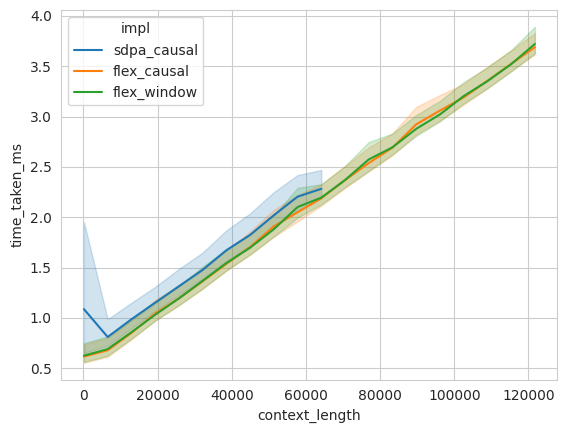

In [8]:
df = pd.DataFrame(data)
sns.lineplot(df, x='context_length', y='time_taken_ms', hue='impl');

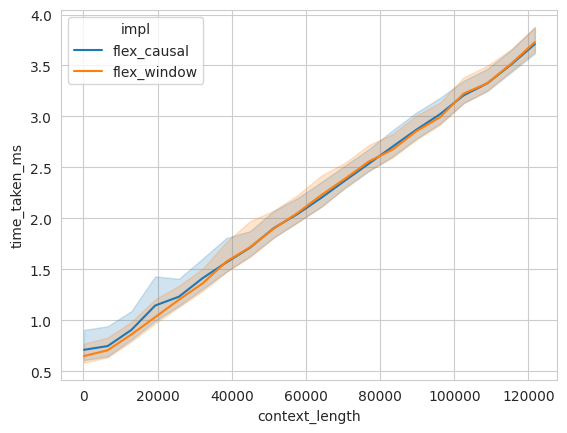

In [56]:
df_subset = df[df['impl'].isin(['flex_causal', 'flex_window'])]
sns.lineplot(df_subset, x='context_length', y='time_taken_ms', hue='impl');

In [ ]:
sns.lineplot(df, x='context_length', y='memory_used_mb', hue='impl');

In [15]:
df.columns

Index(['impl', 'context_length', 'time_taken_ms', 'memory_used_mb'], dtype='object')

In [16]:
df.to_csv('perf.csv')

In [17]:
torch.__version__

'2.6.0.dev20241114+cu124'

In [18]:
sns.lineplot(x='context_length', y='time_taken_ms', hue='impl');

ValueError: Could not interpret value `context_length` for `x`. Value is a string, but `data` was not passed.